**Loading Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
import os

**Image Loading and augumentations**

**Trained on a subset of data from [Kaggle Signature Dataset](https://www.kaggle.com/robinreni/signature-verification-dataset).** Took only 10 classes

In [ ]:
train_directory = 'sign_data_kaggle_modified/train'
test_directory = 'sign_data_kaggle_modified/test'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.1
)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size = (224, 224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size=32
    
)


test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size = (224, 224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size=32
)

Found 200 images belonging to 10 classes.
Found 39 images belonging to 10 classes.


**Import pretrained Models**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

vgg_basemodel = VGG16(include_top=True)
resnet_basemodel = ResNet50(include_top=True)

**Defining Callbacks**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
# checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

**VGG16 Feature extractor**  
Removing the last layer and add a 10 class softmax layer (I took only 10 classes from the kaggle dataset, I recommend you to train it with the whole dataset for the best results)

In [ ]:
vgg_model = tf.keras.Sequential(vgg_basemodel.layers[:-1])
vgg_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

# Freezing original layers
for layer in vgg_model.layers[:-1]:
    layer.trainable = False

vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, lr=0.001, decay=0.01),
                  metrics=['accuracy'])

history = vgg_model.fit(train_generator,
              epochs=30,
              batch_size=64,
              validation_data=test_generator,
              callbacks=[early_stopping])

# finetuning with all layers set trainable

for layer in vgg_model.layers:
    layer.trainable = True

vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, lr=0.0001),
                  metrics=['accuracy'])

history2 = vgg_model.fit(train_generator,
              epochs=5,
              batch_size=64,
              validation_data=test_generator,
              callbacks=[early_stopping])

vgg_model.save('saved_models/vgg_finetuned_model')

**ResNet50 Feature extractor**  
The paper describes to use the output of second last convolutional layer of ResNet50 as a feature extractor. But didn't used the ResNet as I was getting good results with using VGG16 alone. I recommend you to try out this. 

In [ ]:
resnet_basemodel.summary()

In [ ]:
# from tensorflow.python.keras.layers import Lambda;

# def lambda_layer(layers):

#     fc2_norm = K.l2_normalize(fc2, axis = 3);
#     illum_est = tf.reduce_sum(fc2_norm, axis = (1, 2));
#     illum_est = K.l2_normalize(illum_est);

#     return illum_est;

# illum_est = Lambda(norm)(fc2);


# input = resnet_basemodel.input
# x = tf.keras.layers.Flatten()(resnet_basemodel.get_layer('conv5_block3_2_conv').output)
# output = tf.keras.layers.Dense(10, activation='softmax')

# resnet_model = tf.keras.Model(inputs=[input], outputs=[output])

In [ ]:
# resnet_model = tf.keras.Sequential(resnet_basemodel.layers[:-1])

In [ ]:
# resnet_model = tf.keras.Sequential(resnet_basemodel.layers[-9])
# resnet_model.add(tf.keras.layers.Flatten())
# resnet_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

# for layer in resnet_model.layers[:-9]:
#     layer.trainable = False

# resnet_model.compile(loss='categorical_crossentropy',
#                   optimizer=tf.keras.optimizers.SGD(momentum=0.9, lr=0.001, decay=0.01),
#                   metrics=['accuracy'])

# history = resnet_model.fit(train_generator,
#               epochs=30,
#               batch_size=32,
#               validation_data=test_generator,
#               callbacks=[early_stopping])

# # finetuning with all layers set trainable

# for layer in resnet_model.layers:
#     layer.trainable = True

# resnet_model.compile(loss='categorical_crossentropy',
#                   optimizer=tf.keras.optimizers.SGD(momentum=0.9, lr=0.0001),
#                   metrics=['accuracy'])

# history2 = resnet_model.fit(train_generator,
#               epochs=5,
#               batch_size=64,
#               validation_data=test_generator,
#               callbacks=[early_stopping])

# resnet_model.save('saved_models/resnet_finetuned_model')

**Loading Finetuned Model & Feature Extraction**  
[[1]](https://arxiv.org/abs/2004.12104) paper uses the output from the first fully connected layer of the VGG16 as the features for finding cosine similarity.

In [ ]:
# resnet_model = tf.keras.Sequential(resnet_basemodel.layers[-9])
# resnet_model.add(tf.keras.layers.Flatten())
# resnet_model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
vgg_model = tf.keras.models.load_model('saved_models/vgg_finetuned_model')
feature_extractor = tf.keras.Sequential(vgg_model.layers[:-1])

**Extracting Features and calculating Cosine Similarities**

In [ ]:
def load_image(image_path):
    '''Return the image in the format required by VGG16 model.'''
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

def extract_features(paths):
    '''Returns the features extracted by the model.'''
    feature_list = []
    for images in paths:
        features = {}
        features['anchor'] = feature_extractor.predict(load_image(images[0]))
        features['negative'] = feature_extractor.predict(load_image(images[1]))
        features['positive'] = feature_extractor.predict(load_image(images[2]))
        feature_list.append(features)
        
    return feature_list

def cosine_similarity_fn(feature_list):
    '''Returns the cosine similarity between the two signature images.'''
    cosine_similarities = []
    for path in feature_list:
        similarities = {}
        similarities['matching_pair_score'] = cosine_similarity(path['positive'], path['anchor'])[0][0]
        similarities['non_matching_pair_score'] = cosine_similarity(path['negative'], path['anchor'])[0][0]
        cosine_similarities.append(similarities)
    return cosine_similarities


root = 'sign_data_kaggle_modified/my_tests/'
image_set = []
directories = sorted(os.listdir(root))

for directory in directories:
    current_root = os.path.join(root, directory)
    image_set.append([os.path.join(current_root, img) for img in sorted(os.listdir(current_root))])

feature_set = extract_features(image_set)
cosine_similarities = cosine_similarity_fn(feature_set)

**Ploting Sample Signature Pairs**

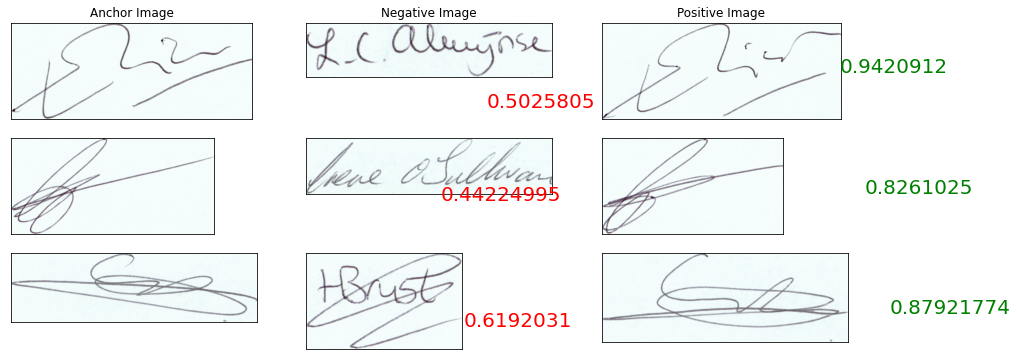

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 6), facecolor='w', edgecolor='k')


for i, cs in enumerate(cosine_similarities):
    axs[i][0].imshow(plt.imread(image_set[i][0]))
    axs[i][1].imshow(plt.imread(image_set[i][1]))
    axs[i][2].imshow(plt.imread(image_set[i][2]))

    axs[i][1].text(450, 210, cs['non_matching_pair_score'],fontsize = 20, color ="red")
    axs[i][2].text(950, 200, cs['matching_pair_score'],fontsize = 20, color ="green")

    axs[i][0].set_anchor('NW')
    axs[i][1].set_anchor('NW')
    axs[i][2].set_anchor('NW')

for ax in fig.axes:
    ax.set_yticks([])
    ax.set_xticks([])

for ax, col in zip(axs[0], ['Anchor Image', 'Negative Image', 'Positive Image']):
    ax.set_title(col)